# Neuro-Symbolic AI
## Sort-of-CLEVR Dataset
### Contents
- Generate Dataset
- Perception Module
    - Train
    - Inference
- Semantic Parser
    - Preprocess Data
    - Train Seq2Seq Model
    - Inference
- Program Executor
- Plugging Everything Together

In [ ]:
# !pip install torchtext --upgrade

In [ ]:
# !git clone https://github.com/nerdimite/neuro-symbolic-ai-soc

In [ ]:
# cd neuro-symbolic-ai-soc

In [1]:
from data_generator import *
import numpy as np
import pandas as pd
import os
import dlib
import cv2
from skimage.io import imshow
from sklearn.metrics.pairwise import cosine_similarity
import torch
from torch import nn
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision import transforms as tfms
from PIL import Image

import matplotlib.pyplot as plt
%matplotlib inline

/projects/tir4/users/pfernand/miniconda3/envs/neuro-symbolic/lib/python3.7/site-packages/skimage/io/manage_plugins.py:23: UserWarning: Your installed pillow version is < 7.1.0. Several security issues (CVE-2020-11538, CVE-2020-10379, CVE-2020-10994, CVE-2020-10177) have been fixed in pillow 7.1.0 or higher. We recommend to upgrade this library.
  from .collection import imread_collection_wrapper


## Dataset Generation

### Breakdown

In [114]:
# Generate a sample i.e.
# a tuple of 1 image, 6 objects' properties, 20 QA vectors (10 relational and 10 non-relational)
sample = build_sample()

In [115]:
# Break down the sample
img, objects, queries, programs, answers = convert_sample(sample)

In [116]:
img = (img * 255).astype('uint8')

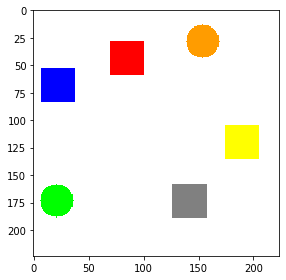

In [117]:
imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

In [118]:
objects

[(0, array([85, 43]), 'r', (70, 28, 100, 58)),
 (1, array([ 21, 173]), 'c', (6, 158, 36, 188)),
 (2, array([22, 68]), 'r', (7, 53, 37, 83)),
 (3, array([154,  28]), 'c', (139, 13, 169, 43)),
 (4, array([142, 173]), 'r', (127, 158, 157, 188)),
 (5, array([190, 120]), 'r', (175, 105, 205, 135))]

In [119]:
list(zip(queries, answers, programs))

[('What is the closest shape to the gray object?',
  'rectangle',
  'filter gray <nxt> relate closest <nxt> query shape'),
 ('What is the closest shape to the red object?',
  'rectangle',
  'filter red <nxt> relate closest <nxt> query shape'),
 ('What is the closest shape to the orange object?',
  'rectangle',
  'filter orange <nxt> relate closest <nxt> query shape'),
 ('What is the furthest shape from the green object?',
  'circle',
  'filter green <nxt> relate furthest <nxt> query shape'),
 ('What is the furthest shape from the orange object?',
  'circle',
  'filter orange <nxt> relate furthest <nxt> query shape'),
 ('What is the closest shape to the orange object?',
  'rectangle',
  'filter orange <nxt> relate closest <nxt> query shape'),
 ('What is the furthest shape from the yellow object?',
  'circle',
  'filter yellow <nxt> relate furthest <nxt> query shape'),
 ('How many objects of the same shape as the green object are there?',
  '2',
  'filter green <nxt> query shape <nxt> fi

### Generate the full dataset

In [207]:
# Generate the dataset
n_train_imgs = 1000
n_test_imgs = 100

build_dataset(n_train_imgs, data_dir='data/train', prefix='train')
build_dataset(n_test_imgs, data_dir='data/test', prefix='test')

100%|██████████| 100/100 [00:07<00:00, 13.72it/s]


## Perception Module

### Train the Object Detector

In [121]:
%load_ext autoreload
%autoreload 2
from perception import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [122]:
def load_image_data(csv_file, img_dir):
    '''Load the image detection data for training the object detector'''
    # Annotations
    annot = pd.read_csv(csv_file)
    
    data = {}
    for i in range(len(os.listdir(img_dir))):
        # Get all rows belonging to the same scene
        scene = annot[annot['filename'] == f'{i}.jpg']
        # Read the image
        img = cv2.imread(os.path.join(img_dir, f'{i}.jpg'))
        
        # Add bounding box information for dlib
        bboxes = []
        for row in scene.values:
            x1, y1, x2, y2 = row[-4:]
            dlib_box = dlib.rectangle(left=x1 , top=y1, right=x2, bottom=y2)
            bboxes.append(dlib_box)
        
        data[i] = (img, bboxes)
    
    return data

In [123]:
# Load the Image Detection Data
det_data = load_image_data('data/train/train_img_det.csv', 'data/train/images')

In [124]:
%%time
# Train the Model
train_detector(det_data, 'detector.svm')

training...
evaluating...
Training Results: precision: 1, recall: 1, average precision: 1
Saved the model to detector.svm
CPU times: user 18.6 s, sys: 480 ms, total: 19.1 s
Wall time: 19.1 s


### Shape Classifier

In [127]:
class Binarize():
    '''PyTorch Transforms Object'''
    def __init__(self):
        '''Converts Grayscale to Binary (except white every other color is zeroed)'''
        pass
    
    def __call__(self, img_tensor):
        '''
        Args:
            img_tensor (tensor): 0-1 scaled tensor with 1 channel
        Returns:
            tensor
        '''
        return (img_tensor > 0.95).float()

In [128]:
# Load the images
shapes_data = ImageFolder('data/shapes_data/', transform=tfms.Compose([tfms.Grayscale(), 
                                                                       tfms.Resize((40, 40)), 
                                                                       tfms.ToTensor(),
                                                                       Binarize()]))

In [129]:
shapes_data.class_to_idx

{'circle': 0, 'rectangle': 1}

In [130]:
# Create the dataloader
shapes_loader = DataLoader(shapes_data, batch_size=20, shuffle=True)

In [131]:
# Model
shape_classifier = ShapeClassifier()

In [132]:
# Train
shape_classifier.train_classifier(shapes_loader, lr=0.0001, epochs=50, filename='classifier.pth')

Epoch 1:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 1: Mean Loss = 0.6039887468020121


Epoch 2:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 2: Mean Loss = 0.41530174513657886


Epoch 3:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 3: Mean Loss = 0.28334113707145053


Epoch 4:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 4: Mean Loss = 0.21128164728482565


Epoch 5:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 5: Mean Loss = 0.1406902658442656


Epoch 6:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 6: Mean Loss = 0.10996548707286517


Epoch 7:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 7: Mean Loss = 0.10069673632582028


Epoch 8:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 8: Mean Loss = 0.07142693952967723


Epoch 9:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 9: Mean Loss = 0.06024649366736412


Epoch 10:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 10: Mean Loss = 0.05058538603285948


Epoch 11:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 11: Mean Loss = 0.05192858663698038


Epoch 12:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 12: Mean Loss = 0.04181222307185332


Epoch 13:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 13: Mean Loss = 0.03656678864111503


Epoch 14:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 14: Mean Loss = 0.024312425404787064


Epoch 15:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 15: Mean Loss = 0.024032527580857277


Epoch 16:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 16: Mean Loss = 0.022771989771475393


Epoch 17:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 17: Mean Loss = 0.019302071848263342


Epoch 18:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 18: Mean Loss = 0.01842119498178363


Epoch 19:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 19: Mean Loss = 0.025032054555291932


Epoch 20:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 20: Mean Loss = 0.017528797111784417


Epoch 21:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 21: Mean Loss = 0.013958399494489035


Epoch 22:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 22: Mean Loss = 0.010131571674719453


Epoch 23:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 23: Mean Loss = 0.006331861678821345


Epoch 24:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 24: Mean Loss = 0.006302978338984151


Epoch 25:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 25: Mean Loss = 0.005082986395185192


Epoch 26:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 26: Mean Loss = 0.005988985261258979


Epoch 27:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 27: Mean Loss = 0.0054282959511814015


Epoch 28:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 28: Mean Loss = 0.006267320403518776


Epoch 29:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 29: Mean Loss = 0.006877205606239538


Epoch 30:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 30: Mean Loss = 0.005691822113779684


Epoch 31:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 31: Mean Loss = 0.005923641370221351


Epoch 32:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 32: Mean Loss = 0.006991453391189377


Epoch 33:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 33: Mean Loss = 0.004987677481646339


Epoch 34:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 34: Mean Loss = 0.006412222593401869


Epoch 35:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 35: Mean Loss = 0.004457140884672602


Epoch 36:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 36: Mean Loss = 0.004063519629805039


Epoch 37:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 37: Mean Loss = 0.0034285787163147083


Epoch 38:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 38: Mean Loss = 0.0038835076071942845


Epoch 39:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 39: Mean Loss = 0.0027358955315624676


Epoch 40:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 40: Mean Loss = 0.008126459074749922


Epoch 41:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 41: Mean Loss = 0.002690923400223255


Epoch 42:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 42: Mean Loss = 0.0016404708973520126


Epoch 43:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 43: Mean Loss = 0.0011844646166233967


Epoch 44:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 44: Mean Loss = 0.001179079437861219


Epoch 45:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 45: Mean Loss = 0.0033490405233654505


Epoch 46:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 46: Mean Loss = 0.0007484110380270673


Epoch 47:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 47: Mean Loss = 0.0005243754155041339


Epoch 48:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 48: Mean Loss = 0.0006068495325356101


Epoch 49:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 49: Mean Loss = 0.001965579286964688


Epoch 50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 50: Mean Loss = 0.001407960621387853


### Perception Pipeline
`detector -> attribute (shape and color) extraction -> structural scene representation`

In [133]:
# Load the Model
perceiver = PerceptionPipe('detector.svm', 'classifier.pth', device='cuda')

### Breakdown

In [134]:
# Inference with Detector
objects = perceiver.detect(img)
# objects
# for img in objects:
#    cv2.imshow('frame', img[0])
#    break

In [28]:
# View the isolated objects (this will not work in colab as its headless)
# for obj, _ in objects:
#     cv2.imshow('frame', obj)
#     cv2.waitKey(0)
#     cv2.destroyAllWindows()

In [135]:
# Inference with Attribute Extractor (Shape Classifier, Color Extractor)
shape, color = perceiver.extract_attributes(objects[3][0])
print(f'Shape = {shape}\nColor = {color}')

Shape = rectangle
Color = red


(40, 40)


  0%|          | 0/1000 [00:00<?, ?it/s]

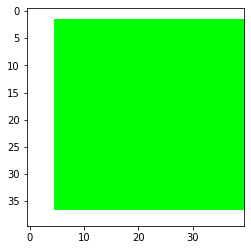

In [136]:
explanation = perceiver.explain(objects[3][0])

from skimage.segmentation import mark_boundaries

temp, mask = explanation.get_image_and_mask(0, positive_only=False, num_features=5, hide_rest=True)

plt.imshow(mark_boundaries(temp, mask))

### Pipeline

In [138]:
scene = perceiver.scene_repr(img)
scene

(       shape   color    position
 0  rectangle  yellow  (191, 120)
 1  rectangle    gray  (143, 172)
 2     circle  orange   (155, 28)
 3  rectangle     red    (83, 44)
 4     circle   green   (19, 172)
 5  rectangle    blue    (19, 68),
        shape   color    position
 0  rectangle  yellow  (191, 120)
 1  rectangle    gray  (143, 172)
 2     circle  orange   (155, 28)
 3  rectangle     red    (83, 44)
 4     circle   green   (19, 172)
 5  rectangle    blue    (19, 68))

## Semantic Parser

### Preprocess Data

In [208]:
from semantic_parser import *
from torchtext.legacy.data import BucketIterator

In [209]:
# Create the preprocessor object and preprocess
preproc = Preprocessor('data/train/train_q2p.csv')

In [210]:
# Get the dataset object
train_data = preproc.train_data

In [211]:
# Looking at the Vocabulary
preproc.prog_f.vocab.stoi

defaultdict(<bound method Vocab._default_unk_index of <torchtext.legacy.vocab.Vocab object at 0x7fb8bc4143d0>>,
            {'<unk>': 0,
             '<pad>': 1,
             '<sos>': 2,
             '<eos>': 3,
             '<nxt>': 4,
             'filter': 5,
             'query': 6,
             'shape': 7,
             'position': 8,
             'relate': 9,
             'blue': 10,
             'isleft': 11,
             'closest': 12,
             'orange': 13,
             'count': 14,
             'green': 15,
             'red': 16,
             'gray': 17,
             'furthest': 18,
             'istop': 19,
             'yellow': 20})

In [212]:
# Looking at the Vocabulary
preproc.que_f.vocab.stoi

defaultdict(<bound method Vocab._default_unk_index of <torchtext.legacy.vocab.Vocab object at 0x7fb8bc414c10>>,
            {'<unk>': 0,
             '<pad>': 1,
             '<sos>': 2,
             '<eos>': 3,
             'the': 4,
             '?': 5,
             'object': 6,
             'is': 7,
             'shape': 8,
             'there': 9,
             'what': 10,
             'a': 11,
             'on': 12,
             'of': 13,
             'blue': 14,
             'left': 15,
             'closest': 16,
             'to': 17,
             'orange': 18,
             'are': 19,
             'as': 20,
             'how': 21,
             'many': 22,
             'objects': 23,
             'same': 24,
             'green': 25,
             'red': 26,
             'gray': 27,
             'from': 28,
             'furthest': 29,
             'top': 30,
             'yellow': 31})

### Training

In [219]:
# Training hyperparameters
num_epochs = 2
learning_rate = 1e-4
batch_size = 32
num_steps = len(train_data) / batch_size

# Model hyperparameters
config = {
    'que_vocab_size': len(preproc.que_f.vocab),
    'prog_vocab_size': len(preproc.prog_f.vocab),
    'embedding_dim': 256,
    'num_heads': 8,
    'num_encoder_layers': 3,
    'num_decoder_layers': 3,
    'dropout': 0.10,
    'max_len': 20,
    'forward_expansion': 4,
    'que_pad_idx': preproc.que_f.vocab.stoi["<pad>"]
}

In [220]:
# Save the config as a json file
import json
with open('config.json', 'w') as f:
    json.dump(config, f)

In [221]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [222]:
# Create Training Generator
train_loader = BucketIterator.splits((train_data,),
                                     batch_size=batch_size,
                                     sort_within_batch=True,
                                     sort_key=lambda x: len(x.query),
                                     device=device)[0]

In [223]:
# Create Model
seq2seq = Seq2Seq(config)

In [224]:
%%time
# Train Model
seq2seq.train_model(train_loader, num_epochs, num_steps, filename='semantic_parser.pth')

Epoch 1:   0%|          | 0/625.0 [00:00<?, ?it/s]

Epoch 1: Mean Loss = 0.08652594459345564



Epoch 2:   0%|          | 0/625.0 [00:00<?, ?it/s]

Epoch 2: Mean Loss = 0.0004301094287540764

CPU times: user 39.1 s, sys: 297 ms, total: 39.4 s
Wall time: 42.4 s


### Inference on Queries

In [225]:
sem_parser = SemanticParser(preproc, config)

In [226]:
query = 'What is the furthest shape from the green object?'
program = sem_parser.predict(query)
program

['closest red <sos> red <sos> red <sos> red red <sos> closest red red <sos> closest red closest red <sos>']

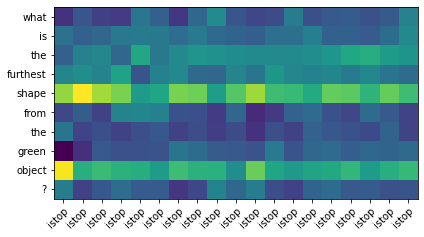

In [203]:
program, attn = sem_parser.predict(query, return_attns=True, raw_prog=True)
tokens = sem_parser.preproc.tokenizer(query)
attn = attn.cpu()
fig, ax = plt.subplots()
im = ax.imshow(attn)

# We want to show all ticks...
ax.set_xticks(np.arange(len(program)))
ax.set_yticks(np.arange(len(tokens)))
# ... and label them with the respective list entries
ax.set_xticklabels(program)
ax.set_yticklabels(tokens)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
# for i in range(len(tokens)):
#     for j in range(len(program)):
#         text = ax.text(j, i, attn[i, j],
#                       ha="center", va="center", color="w")

ax.set_title("")
fig.tight_layout()
plt.show()

## Program Executor

In [204]:
from program_executor import ProgramExecutor

In [205]:
executor = ProgramExecutor()

In [206]:
queries

['What is the closest shape to the gray object?',
 'What is the closest shape to the red object?',
 'What is the closest shape to the orange object?',
 'What is the furthest shape from the green object?',
 'What is the furthest shape from the orange object?',
 'What is the closest shape to the orange object?',
 'What is the furthest shape from the yellow object?',
 'How many objects of the same shape as the green object are there?',
 'What is the closest shape to the gray object?',
 'What is the furthest shape from the red object?',
 'Is there a gray object on the left?',
 'What is the shape of the gray object?',
 'Is there a green object on the left?',
 'What is the shape of the green object?',
 'Is there a red object on the left?',
 'Is there a blue object on the top?',
 'What is the shape of the yellow object?',
 'What is the shape of the gray object?',
 'Is there a green object on the left?',
 'Is there a gray object on the left?']

In [156]:
# Run the program executor with on a full sample of 20 queries
pred_ans = []
for que in queries:
    program = sem_parser.predict(que)
    pred_ans.append(executor(scene, program))

TypeError: tuple indices must be integers or slices, not str

In [113]:
list(zip(pred_ans, answers))

[]

## Plugging Everything Together

In [49]:
from program_executor import *
from perception import *
from semantic_parser import *
import torch
from skimage.io import imshow
import cv2

In [52]:
# Load the config file for transformers
import json
with open('config.json', 'r') as f:
    config = json.load(f)

In [53]:
class NSAIPipeline():
    '''End-to-End Pipeline of Neuro-Symbolic AI on Sort-of-CLEVR dataset'''
    def __init__(self, 
                 config,
                 detector='models/detector.svm',
                 classifier='models/classifier.pth',
                 sem_parser='models/semantic_parser.pth',
                 train_csv='data/train/train_q2p.csv',
                 device=None):
        
        if device is None:
            device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.device = device
        
        # Perception Module
        self.perceiver = PerceptionPipe(detector, classifier, self.device)
        
        # Semantic Parser
        self.preproc = Preprocessor(train_csv)
        self.sem_parser = SemanticParser(self.preproc, config, filename=sem_parser, device=self.device)
        
        # Program Executor
        self.executor = ProgramExecutor()
        
    def predict(self, img, query):
        '''
        Make Prediction on a single image and question pair
        
        Args:
            img (str/array): pixel values should be in 0-255 range
                             of dtype uint8 in BGR color format or
                             file path of the image
            query (str): question about the image
            
        Returns:
            str: answer of the query
        '''
        # Load img if it's a path
        if type(img) == str:
            img = cv2.imread(img)
        
        # Structured Scene Representation
        scene = self.perceiver.scene_repr(img)
        # Synthesize Program from Query
        program = self.sem_parser.predict(query)
        # Execute Program
        answer = self.executor(scene, program)
        
        return answer, program
    
    def evaluate(self, csv, img_dir, debug=True):
        '''
        Evaluate the model on a dataset
        
        Args:
            csv (str): path of the csv containing image filename, answer, query and program
            img_dir (str): directory containing the images
            debug (bool): View the data points which were wrong
        Returns:
            int: accuracy of the model
        '''
        data = pd.read_csv(csv).values
        
        correct = []
        for filename, answer, query, program in tqdm(data):
            # Load Image
            img_path = os.path.join(img_dir, filename)
            img = cv2.imread(img_path)
            
            # Make prediction
            pred, pred_prog = self.predict(img, query)
            
            # Verify answer
            if str(pred) == answer:
                correct.append(1)
            else:
                if debug:
                    print(filename, answer, pred, query, pred_prog)
                correct.append(0)
        
        acc = (sum(correct) / len(correct)) * 100
        
        return acc

In [54]:
nsai = NSAIPipeline(config)

In [55]:
nsai.predict('data/test/images/1.jpg', 'How many objects of the same shape as the gray object are there?')

(6, ['filter gray', 'query shape', 'filter', 'count'])

In [59]:
# Evaluate on the test and get the accuracy
nsai.evaluate('data/test/test_q2p.csv', 'data/test/images/', debug=False)

99.0

---
#### Debugging

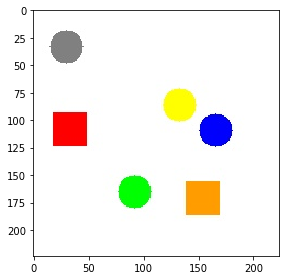

In [60]:
img2 = cv2.imread('data/train/images/2.jpg')
imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))

In [61]:
nsai.executor.scene = nsai.perceiver.scene_repr(img2)
nsai.executor.scene

,shape,color,position
0,rectangle,orange,"(155, 172)"
1,rectangle,red,"(31, 108)"
2,circle,gray,"(31, 32)"
3,circle,green,"(91, 164)"
4,circle,blue,"(167, 108)"
5,circle,yellow,"(131, 84)"


In [78]:
# program = nsai.sem_parser.predict('How many objects of the same shape as the red object are there? ')
# program

In [80]:
# nsai.executor.count(nsai.executor.filter_(nsai.executor.query(nsai.executor.filter_('red'), 'shape')))